# Step 0: Why EDA?
Not all data comes in a neat little package ready to be modelled by the latest and greatest machine learning models.

Most of the time, you'll get a dataset you don't know much about. So before you can make any solid predictions, you'll to find out more.

This is where EDA comes in.

The main thing to remember is the first word. Exploratory. You're trying to figure out more about the data so you can build a model the best way you can.

You'll usually do this when you first look at a dataset but it'll continually happen as you learn more. EDA is an iterative process. There's no one way to do it either. It'll vary with each new dataset but there are some things you'll find yourself doing more often, we'll talk about those in this notebook and in a future blog post.

# Step 1: Download the data
You can download the data for this notebook here: https://www.kaggle.com/c/titanic/data

# Step 2: Work through the notebook
First we will import all the relevant dependencies we need.

If you don't have any of these, the notebook will throw an error. The error will likely tell you what you don't have. Then you'll have to install it.

You can usually figure out how to install it by Googling: "how to install [the thing you don't have]".

PS If you have any questions, feedback, advice or bug fixes, please let me know.

In [22]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning Libraries
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

## Loading in the data
Loading the data from data folder after downloading

In [4]:
# Import train & test data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv') # example of what a submission should look like

In [5]:
# Viewing train data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
len(train)

891

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data Descriptions
- Survival: 0 = No, 1 = Yes
- pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Sex
- Age: Age in years
- sibsp: number of siblings/spouses aboard the Titanic
- parch: number of parents/children aboard the Titanic
- ticket: Ticket number
- fare: Passenger fare
- cabin: Cabin number
- embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Find missing values

Find all the missing values in the dataframe. These are rows which are missing a value or have NaN instead of something like the rest of the column.

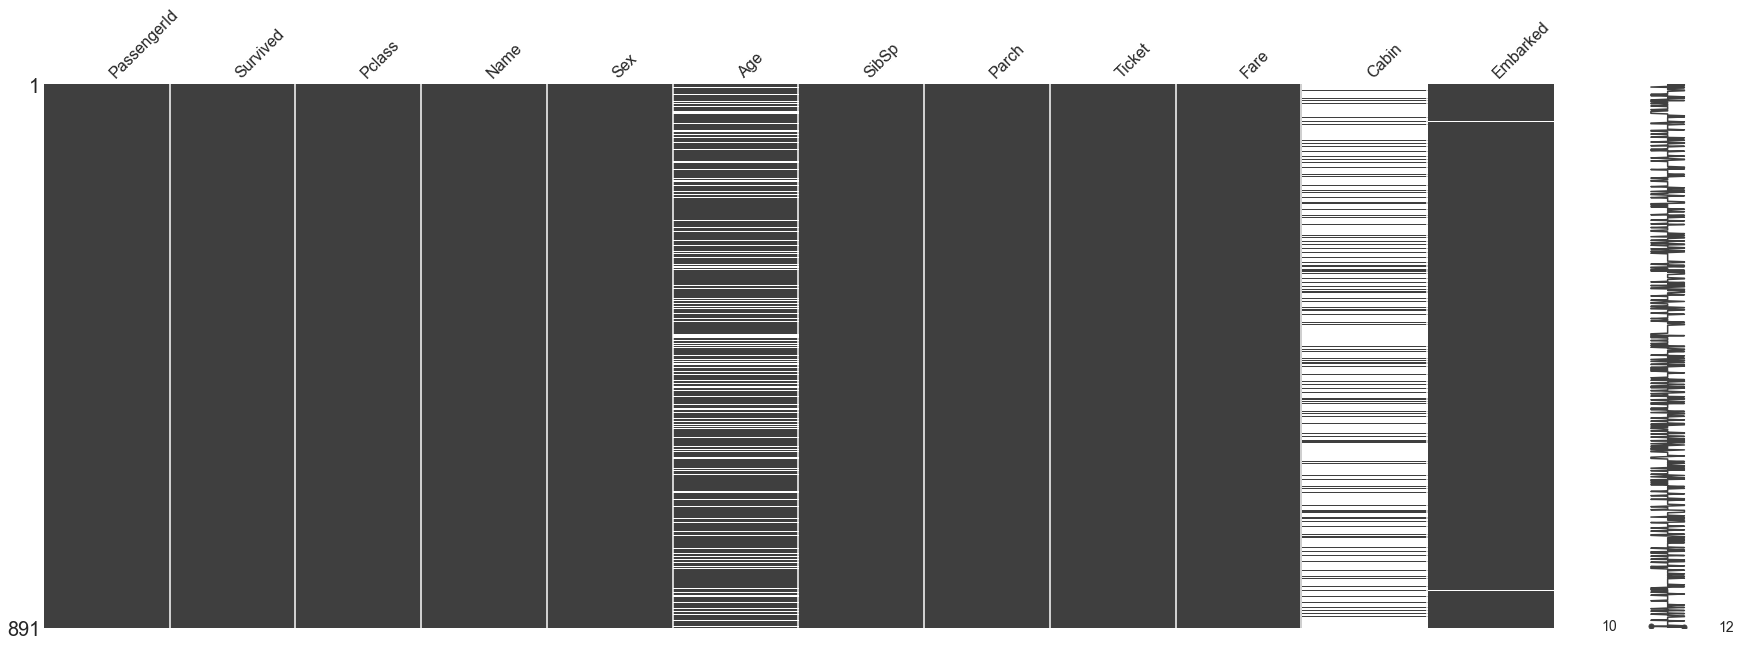

In [9]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10))

In [10]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform our data analysis, let's create two new dataframes
We'll create one for exploring discretised continuous variables (continuous variables which have been sorted into some kind of category) and another for exploring continuous variables.



In [11]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

## What datatypes are in the dataframe?
As a general rule of thumb, features with a datatype of object could be considered categorical features. And those which are floats or ints (numbers) could be considered numerical features.

However, as we dig deeper, we might find features which are numerical may actually be categorical.

The goal for the next few steps is to figure out how best to process the data so our machine learning model can learn from it.

Ideally, all the features will be encoded into a numerical value of some kind.

In [12]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Exploring each of these features individually
We'll go through each column iteratively and see which ones to use in our first models. Some may need more preprocessing than others to get ready.

## Target Feature: Survived
Description: Whether the passenger survived or not.

Key: 0 = did not survive, 1 = survived

This is the variable we want our machine learning model to predict based off all the others.

0    549
1    342
Name: Survived, dtype: int64


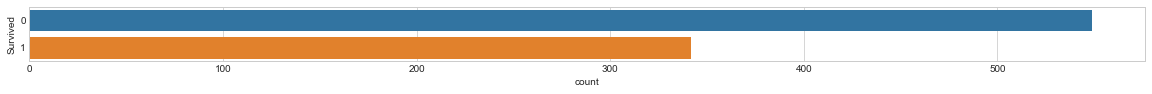

In [15]:
# How many people survived?
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [17]:
# Adding this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

## Feature: Pclass
Description: The ticket class of the passenger.

Key: 1 = 1st, 2 = 2nd, 3 = 3rd

Let's plot the distribution
We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.

For example, if there are values which are completely outside of the distribution, we may not want to include them in our model.

We can see with this feature, the values are numerical (1, 2 and 3) but they are categories.

Q: What is the difference betweeen nominal and ordinal variable?

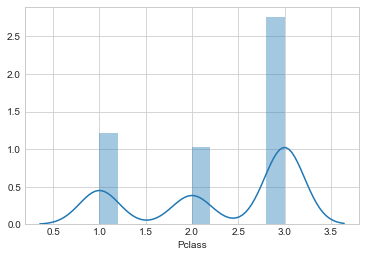

In [18]:
sns.distplot(train.Pclass)

In [19]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

In [21]:
# Since there are no missing values in Pclass, let's add it to our sub dataframes.
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

## Feature: Name
Description: The name of the passenger.

In [23]:
# How many different names are there?
train.Name.value_counts()

Perreault, Miss. Anne                                       1
Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)    1
Strandberg, Miss. Ida Sofia                                 1
Stephenson, Mrs. Walter Bertram (Martha Eustis)             1
Olsson, Mr. Nils Johan Goransson                            1
                                                           ..
Louch, Mrs. Charles Alexander (Alice Adelaide Slow)         1
Ayoub, Miss. Banoura                                        1
Braund, Mr. Lewis Richard                                   1
Harris, Mrs. Henry Birkhardt (Irene Wallach)                1
Stoytcheff, Mr. Ilia                                        1
Name: Name, Length: 891, dtype: int64

Name variable can be used diffently, for the purpose of this EDA this won't be done.
- Hint: Mrs., Miss., Mr., Dr..

##  Feature: Sex
Description: The sex of the passenger (male or female).

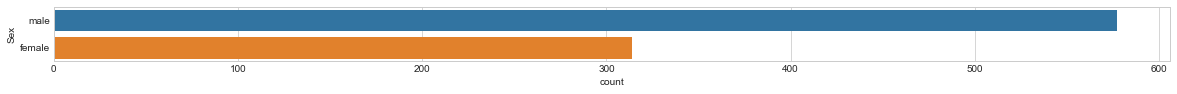

In [26]:
plt.figure(figsize=(20, 1))
sns.countplot(y="Sex", data=train)

In [31]:
train.Sex.isnull().sum()

0

In [32]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [34]:
# Add sex to df_bin -> In terms of binary value
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)

# Addin sex to df_con as continues values
df_con['Sex'] = train['Sex']

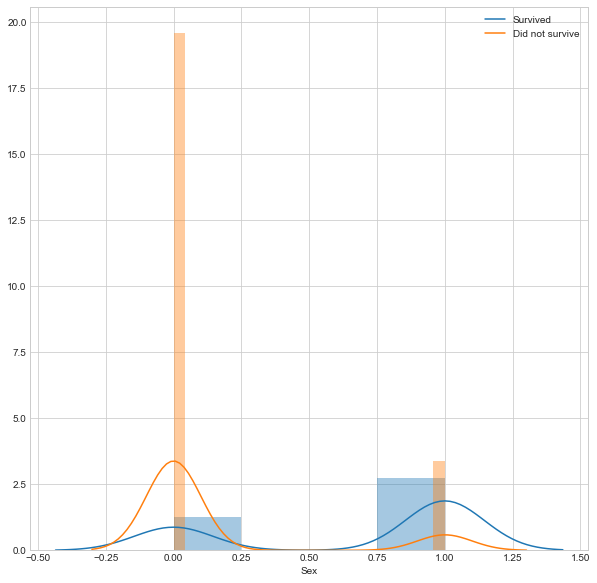

In [35]:
# Plotting how Sex is related to Survival
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

## Feature: Age
Description: The age of the passenger.

Out of a total 891 rows, that's almost one quarter of the dataset.

What would you do with these missing values?

Could replace them with the average age? What's the pro's and con's of doing this?

Or would you get rid of them completely?

We won't answer these questions in our initial EDA but this is something we would definitely revisit at a later date.


In [42]:
train.Age.isnull().sum()

177

In [43]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

## Function to create count and distribution visualisations


In [44]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

## Feature: SibSp
Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [46]:
train.SibSp.isnull().sum()

0

In [49]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [50]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

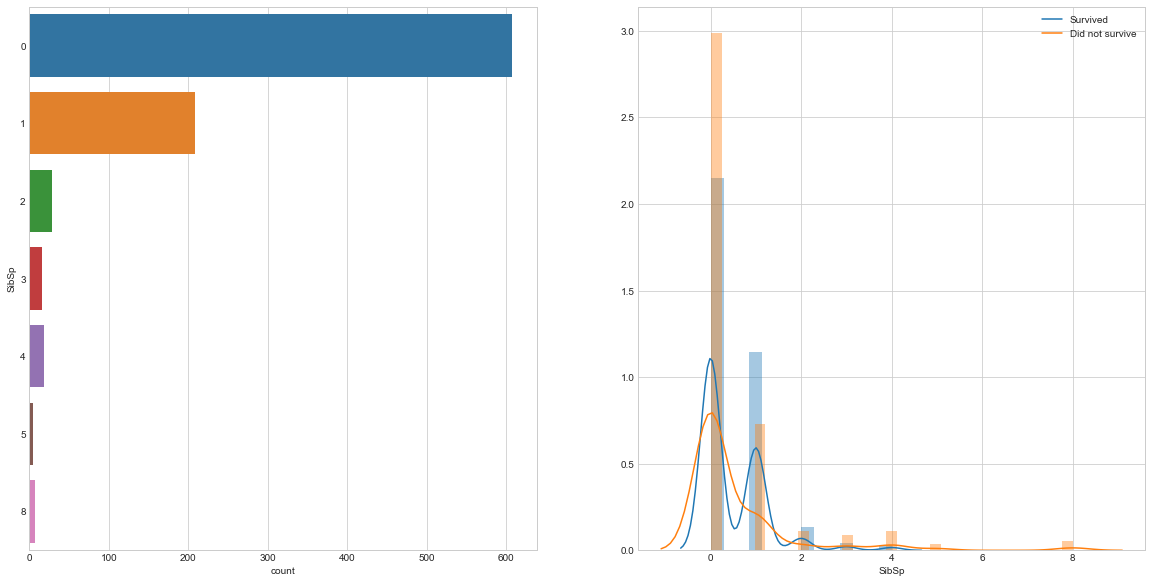

In [51]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

## Feature: Parch
Description: The number of parents/children the passenger has aboard the Titanic.

Since this feature is similar to SibSp, we'll do a similar analysis.

In [53]:
train.Parch.isnull().sum()

0

In [55]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

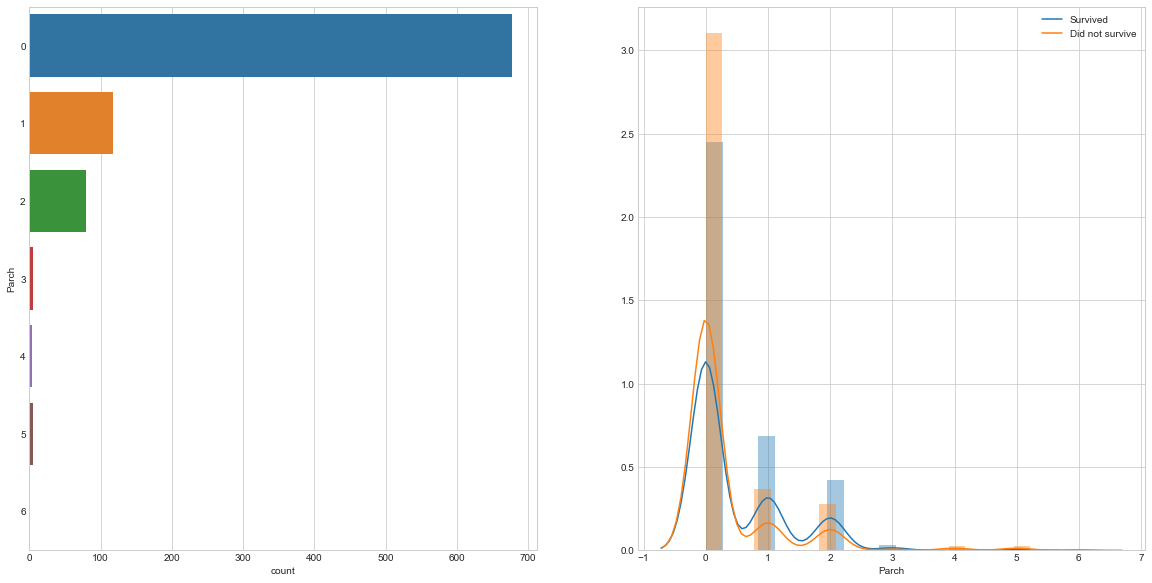

In [56]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

## Feature: Ticket
Description: The ticket number of the boarding passenger.

In [60]:
train.Ticket.isnull().sum()

0

In [62]:
train.Ticket.value_counts()

1601          7
347082        7
CA. 2343      7
3101295       6
CA 2144       6
             ..
365226        1
315086        1
C.A. 24580    1
349218        1
113059        1
Name: Ticket, Length: 681, dtype: int64

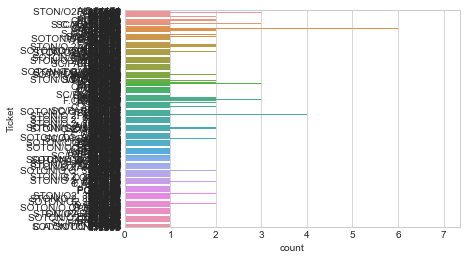

In [65]:
sns.countplot(y="Ticket", data=train)

In [70]:
# Different types of tickets
print("Different types of tickets are: %d" % (len(train.Ticket.unique())))

Different types of tickets are: 681


Initail EDA can exclude how to group Ticket column

## Feature: Fare
Description: How much the ticket cost.

In [71]:
train.Fare.isnull().sum()

0

In [74]:
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

In [75]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [76]:
# How many unique kinds of Fare are there?
print("There are %d unique Fare values." % len(train.Fare.unique()))

There are 248 unique Fare values.


In [77]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised

In [78]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Fare
0,0,3,0,1,"(-0.512, 102.466]"
1,1,1,1,1,"(-0.512, 102.466]"
2,1,3,1,0,"(-0.512, 102.466]"
3,1,1,1,1,"(-0.512, 102.466]"
4,0,3,0,0,"(-0.512, 102.466]"


In [79]:
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

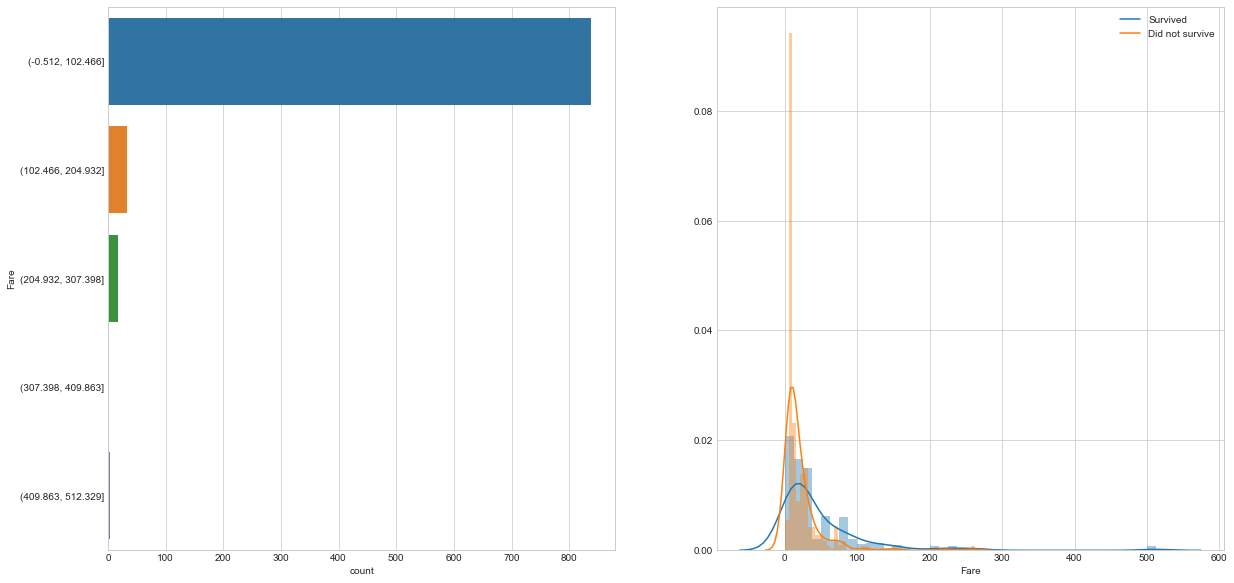

In [81]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

## Feature: Cabin
Description: The cabin number where the passenger was staying.

In [82]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [88]:
# What do the Cabin values look like?
train.Cabin.value_counts().head(40)

B96 B98            4
G6                 4
C23 C25 C27        4
F2                 3
F33                3
D                  3
E101               3
C22 C26            3
E24                2
C65                2
C78                2
E121               2
B35                2
E25                2
E67                2
B57 B59 B63 B66    2
C2                 2
B22                2
C68                2
E44                2
C126               2
D33                2
C123               2
D36                2
B20                2
D17                2
D26                2
B18                2
C93                2
B28                2
B49                2
C92                2
F4                 2
C124               2
E8                 2
C83                2
B77                2
C125               2
E33                2
F G73              2
Name: Cabin, dtype: int64

Since there are too many missing values, we will leave this out

Hint: Using alphabets as a way to categorise them

## Feature: Embarked
Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [89]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [91]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

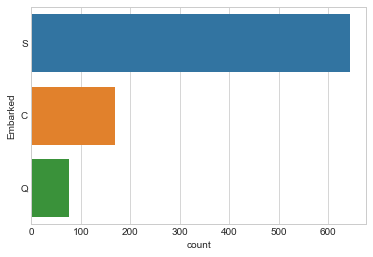

In [92]:
sns.countplot(y="Embarked", data=train)

Since there are 2 missing values, there are 2 ways to handle them:
1. Drop the row which have the missing value
2. Else random fill the value with one of the three (S, C and Q)

In [93]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [95]:
# Remove Embarked rows which are missing values
print(len(df_con), len(df_bin)) # Values before removing the Nan vlues
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con), len(df_bin)) # Values before removing the Nan vlues

889 889
889 889


## Feature Encoding
Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.

In [96]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Fare,Embarked
0,0,3,0,1,"(-0.512, 102.466]",S
1,1,1,1,1,"(-0.512, 102.466]",C
2,1,3,1,0,"(-0.512, 102.466]",S
3,1,1,1,1,"(-0.512, 102.466]",S
4,0,3,0,0,"(-0.512, 102.466]",S


In [97]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Fare,Embarked
0,0,3,male,1,7.2500,S
1,1,1,female,1,71.2833,C
2,1,3,female,0,7.9250,S
3,1,1,female,1,53.1000,S
4,0,3,male,0,8.0500,S


In [99]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,SibSp_5,SibSp_8,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [100]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

[To check as to why OneHotEncoder is better than LabelEncode](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621)

In [101]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [102]:
# Let's look at df_con_enc
df_con_enc.head(20)

,Survived,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,7.2500,0,0,1,0,1,0,0,1
1,1,1,71.2833,1,0,0,1,0,1,0,0
2,1,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,21.0750,0,0,1,0,1,0,0,1
8,1,0,11.1333,0,0,1,1,0,0,0,1
9,1,1,30.0708,1,0,0,1,0,0,1,0


## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Seperating the data


In [103]:
# Seclect the dataframe we want to use first for predictions
selected_df = df_con_enc

In [104]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [105]:
print(X_train.shape)

(889, 10)


In [106]:
print(y_train.shape)

(889,)


### Define a function to fit machine learning algorithms
Since many of the algorithms we will use are from the sklearn library, they all take similar (practically the same) inputs and produce similar outputs.

To prevent writing code multiple times, we will functionise fitting the model and returning the accuracy scores.

In [107]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression


In [109]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.87
Accuracy CV 10-Fold: 79.19
Running Time: 0:00:00.211994


### K-Nearest Neighbours

In [110]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.35
Accuracy CV 10-Fold: 76.49
Running Time: 0:00:00.444466


### Gaussian Naive Bayes

In [111]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.97
Accuracy CV 10-Fold: 78.07
Running Time: 0:00:00.390500


### Linear Support Vector Machines (SVC

In [112]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:01.501713


### Stochastic Gradient Descent

In [113]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 75.82
Accuracy CV 10-Fold: 67.6
Running Time: 0:00:00.115859


### Decision Tree Classifier

In [114]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.01
Accuracy CV 10-Fold: 80.88
Running Time: 0:00:00.204729


### Gradient Boost Trees

In [115]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.73
Accuracy CV 10-Fold: 81.55
Running Time: 0:00:00.566329


### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

It's simple and easy to use and a goto algorithms.

For more on CatBoost and the methods it uses to deal with categorical variables, check out the CatBoost [docs](https://catboost.ai/).

In [117]:
X_train.head()

,SibSp,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,7.2500,0,0,1,0,1,0,0,1
1,1,71.2833,1,0,0,1,0,1,0,0
2,0,7.9250,0,0,1,1,0,0,0,1
3,1,53.1000,0,0,1,1,0,1,0,0
4,0,8.0500,0,0,1,0,1,0,0,1


In [118]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [120]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features


array([0, 2, 3, 4, 5, 6, 7, 8, 9])

This means Catboost has picked up that all variables except Fare can be treated as categorical.

In [121]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [123]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6869052	total: 76.9ms	remaining: 1m 16s
1:	learn: 0.6805956	total: 82.6ms	remaining: 41.2s
2:	learn: 0.6748683	total: 86.8ms	remaining: 28.9s
3:	learn: 0.6692848	total: 89.3ms	remaining: 22.2s
4:	learn: 0.6637029	total: 92.1ms	remaining: 18.3s
5:	learn: 0.6582842	total: 94.8ms	remaining: 15.7s
6:	learn: 0.6530537	total: 97.4ms	remaining: 13.8s
7:	learn: 0.6474456	total: 101ms	remaining: 12.5s
8:	learn: 0.6426802	total: 103ms	remaining: 11.4s
9:	learn: 0.6394875	total: 105ms	remaining: 10.4s
10:	learn: 0.6347054	total: 108ms	remaining: 9.71s
11:	learn: 0.6295163	total: 111ms	remaining: 9.12s
12:	learn: 0.6250376	total: 113ms	remaining: 8.6s
13:	learn: 0.6204126	total: 116ms	remaining: 8.18s
14:	learn: 0.6158599	total: 119ms	remaining: 7.78s
15:	learn: 0.6114885	total: 121ms	remaining: 7.43s
16:	learn: 0.6073767	total: 123ms	remaining: 7.13s
17:	learn: 0.6031557	total: 137ms	remaining: 7.48s
18:	learn: 0.5991205	total: 151ms	remaining: 7.81s
19:	

220:	learn: 0.4143614	total: 529ms	remaining: 1.86s
221:	learn: 0.4143003	total: 530ms	remaining: 1.86s
222:	learn: 0.4140409	total: 533ms	remaining: 1.86s
223:	learn: 0.4139159	total: 535ms	remaining: 1.85s
224:	learn: 0.4137491	total: 537ms	remaining: 1.85s
225:	learn: 0.4135567	total: 539ms	remaining: 1.85s
226:	learn: 0.4131743	total: 542ms	remaining: 1.84s
227:	learn: 0.4131653	total: 543ms	remaining: 1.84s
228:	learn: 0.4128088	total: 546ms	remaining: 1.84s
229:	learn: 0.4126091	total: 549ms	remaining: 1.84s
230:	learn: 0.4125100	total: 551ms	remaining: 1.83s
231:	learn: 0.4124707	total: 552ms	remaining: 1.83s
232:	learn: 0.4123806	total: 555ms	remaining: 1.82s
233:	learn: 0.4123455	total: 556ms	remaining: 1.82s
234:	learn: 0.4120177	total: 558ms	remaining: 1.82s
235:	learn: 0.4118112	total: 560ms	remaining: 1.81s
236:	learn: 0.4116892	total: 562ms	remaining: 1.81s
237:	learn: 0.4115848	total: 564ms	remaining: 1.8s
238:	learn: 0.4115167	total: 566ms	remaining: 1.8s
239:	learn: 0.

410:	learn: 0.3957862	total: 900ms	remaining: 1.29s
411:	learn: 0.3957815	total: 902ms	remaining: 1.29s
412:	learn: 0.3956945	total: 905ms	remaining: 1.29s
413:	learn: 0.3956059	total: 908ms	remaining: 1.28s
414:	learn: 0.3953977	total: 910ms	remaining: 1.28s
415:	learn: 0.3953699	total: 913ms	remaining: 1.28s
416:	learn: 0.3952421	total: 916ms	remaining: 1.28s
417:	learn: 0.3952126	total: 918ms	remaining: 1.28s
418:	learn: 0.3952125	total: 919ms	remaining: 1.27s
419:	learn: 0.3951671	total: 920ms	remaining: 1.27s
420:	learn: 0.3951670	total: 921ms	remaining: 1.27s
421:	learn: 0.3951057	total: 923ms	remaining: 1.26s
422:	learn: 0.3949680	total: 925ms	remaining: 1.26s
423:	learn: 0.3949479	total: 927ms	remaining: 1.26s
424:	learn: 0.3948003	total: 928ms	remaining: 1.26s
425:	learn: 0.3945490	total: 931ms	remaining: 1.25s
426:	learn: 0.3943917	total: 933ms	remaining: 1.25s
427:	learn: 0.3943058	total: 935ms	remaining: 1.25s
428:	learn: 0.3942359	total: 938ms	remaining: 1.25s
429:	learn: 

588:	learn: 0.3829758	total: 1.26s	remaining: 878ms
589:	learn: 0.3829752	total: 1.26s	remaining: 875ms
590:	learn: 0.3829306	total: 1.26s	remaining: 872ms
591:	learn: 0.3828917	total: 1.26s	remaining: 869ms
592:	learn: 0.3828917	total: 1.26s	remaining: 866ms
593:	learn: 0.3827786	total: 1.26s	remaining: 864ms
594:	learn: 0.3827576	total: 1.26s	remaining: 861ms
595:	learn: 0.3827364	total: 1.27s	remaining: 858ms
596:	learn: 0.3826183	total: 1.27s	remaining: 856ms
597:	learn: 0.3826183	total: 1.27s	remaining: 853ms
598:	learn: 0.3825773	total: 1.27s	remaining: 851ms
599:	learn: 0.3825417	total: 1.27s	remaining: 849ms
600:	learn: 0.3824100	total: 1.27s	remaining: 847ms
601:	learn: 0.3823975	total: 1.28s	remaining: 844ms
602:	learn: 0.3823878	total: 1.28s	remaining: 842ms
603:	learn: 0.3823830	total: 1.28s	remaining: 840ms
604:	learn: 0.3823729	total: 1.28s	remaining: 837ms
605:	learn: 0.3823567	total: 1.28s	remaining: 835ms
606:	learn: 0.3823472	total: 1.29s	remaining: 833ms
607:	learn: 

775:	learn: 0.3710040	total: 1.6s	remaining: 463ms
776:	learn: 0.3709635	total: 1.61s	remaining: 461ms
777:	learn: 0.3709347	total: 1.61s	remaining: 460ms
778:	learn: 0.3707613	total: 1.61s	remaining: 458ms
779:	learn: 0.3706961	total: 1.62s	remaining: 456ms
780:	learn: 0.3706961	total: 1.62s	remaining: 453ms
781:	learn: 0.3705853	total: 1.62s	remaining: 451ms
782:	learn: 0.3704945	total: 1.62s	remaining: 450ms
783:	learn: 0.3704744	total: 1.62s	remaining: 447ms
784:	learn: 0.3704129	total: 1.63s	remaining: 446ms
785:	learn: 0.3702728	total: 1.63s	remaining: 444ms
786:	learn: 0.3701338	total: 1.63s	remaining: 442ms
787:	learn: 0.3701238	total: 1.63s	remaining: 439ms
788:	learn: 0.3700507	total: 1.64s	remaining: 437ms
789:	learn: 0.3700053	total: 1.64s	remaining: 435ms
790:	learn: 0.3700027	total: 1.64s	remaining: 433ms
791:	learn: 0.3699738	total: 1.64s	remaining: 431ms
792:	learn: 0.3698729	total: 1.64s	remaining: 429ms
793:	learn: 0.3697394	total: 1.65s	remaining: 427ms
794:	learn: 0

954:	learn: 0.3568207	total: 1.98s	remaining: 93.3ms
955:	learn: 0.3567765	total: 1.98s	remaining: 91.2ms
956:	learn: 0.3567151	total: 1.98s	remaining: 89.2ms
957:	learn: 0.3566193	total: 1.99s	remaining: 87.1ms
958:	learn: 0.3566135	total: 1.99s	remaining: 85ms
959:	learn: 0.3565660	total: 1.99s	remaining: 82.9ms
960:	learn: 0.3565066	total: 1.99s	remaining: 80.9ms
961:	learn: 0.3565039	total: 1.99s	remaining: 78.8ms
962:	learn: 0.3563758	total: 2s	remaining: 76.7ms
963:	learn: 0.3563435	total: 2s	remaining: 74.6ms
964:	learn: 0.3563415	total: 2s	remaining: 72.5ms
965:	learn: 0.3563196	total: 2s	remaining: 70.4ms
966:	learn: 0.3562728	total: 2s	remaining: 68.4ms
967:	learn: 0.3562621	total: 2s	remaining: 66.3ms
968:	learn: 0.3561856	total: 2.01s	remaining: 64.2ms
969:	learn: 0.3560961	total: 2.01s	remaining: 62.1ms
970:	learn: 0.3560902	total: 2.01s	remaining: 60ms
971:	learn: 0.3558889	total: 2.01s	remaining: 57.9ms
972:	learn: 0.3557225	total: 2.01s	remaining: 55.9ms
973:	learn: 0.3

### Perform CatBoost cross-validation

In [125]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6749084	test: 0.6752844	best: 0.6752844 (0)	total: 64.1ms	remaining: 1m 4s
1:	learn: 0.6593704	test: 0.6598243	best: 0.6598243 (1)	total: 104ms	remaining: 52.1s
2:	learn: 0.6430640	test: 0.6439058	best: 0.6439058 (2)	total: 153ms	remaining: 50.8s
3:	learn: 0.6307173	test: 0.6315166	best: 0.6315166 (3)	total: 190ms	remaining: 47.3s
4:	learn: 0.6181999	test: 0.6197657	best: 0.6197657 (4)	total: 240ms	remaining: 47.7s
5:	learn: 0.6054945	test: 0.6080176	best: 0.6080176 (5)	total: 287ms	remaining: 47.5s
6:	learn: 0.5944424	test: 0.5971182	best: 0.5971182 (6)	total: 329ms	remaining: 46.7s
7:	learn: 0.5833069	test: 0.5866514	best: 0.5866514 (7)	total: 362ms	remaining: 44.9s
8:	learn: 0.5732015	test: 0.5774755	best: 0.5774755 (8)	total: 393ms	remaining: 43.2s
9:	learn: 0.5639841	test: 0.5691191	best: 0.5691191 (9)	total: 423ms	remaining: 41.8s
10:	learn: 0.5563619	test: 0.5617388	best: 0.5617388 (10)	total: 449ms	remaining: 40.4s
11:	learn: 0.5480983	test: 0.5539459	best: 0.553945

99:	learn: 0.4007681	test: 0.4446789	best: 0.4446789 (99)	total: 3.86s	remaining: 34.7s
100:	learn: 0.4003962	test: 0.4445853	best: 0.4445853 (100)	total: 3.9s	remaining: 34.7s
101:	learn: 0.4000023	test: 0.4444696	best: 0.4444696 (101)	total: 3.96s	remaining: 34.9s
102:	learn: 0.3996008	test: 0.4444522	best: 0.4444522 (102)	total: 3.99s	remaining: 34.8s
103:	learn: 0.3992619	test: 0.4443348	best: 0.4443348 (103)	total: 4.02s	remaining: 34.7s
104:	learn: 0.3989604	test: 0.4442930	best: 0.4442930 (104)	total: 4.06s	remaining: 34.6s
105:	learn: 0.3987023	test: 0.4443461	best: 0.4442930 (104)	total: 4.09s	remaining: 34.5s
106:	learn: 0.3983466	test: 0.4443009	best: 0.4442930 (104)	total: 4.15s	remaining: 34.6s
107:	learn: 0.3979557	test: 0.4442085	best: 0.4442085 (107)	total: 4.19s	remaining: 34.6s
108:	learn: 0.3977315	test: 0.4442328	best: 0.4442085 (107)	total: 4.23s	remaining: 34.6s
109:	learn: 0.3974953	test: 0.4441803	best: 0.4441803 (109)	total: 4.27s	remaining: 34.5s
110:	learn: 0

192:	learn: 0.3758110	test: 0.4428552	best: 0.4428486 (184)	total: 9.43s	remaining: 39.4s
193:	learn: 0.3755977	test: 0.4430542	best: 0.4428486 (184)	total: 9.46s	remaining: 39.3s
194:	learn: 0.3754637	test: 0.4430954	best: 0.4428486 (184)	total: 9.49s	remaining: 39.2s
195:	learn: 0.3752601	test: 0.4430432	best: 0.4428486 (184)	total: 9.52s	remaining: 39s
196:	learn: 0.3750054	test: 0.4429718	best: 0.4428486 (184)	total: 9.55s	remaining: 38.9s
197:	learn: 0.3748280	test: 0.4429462	best: 0.4428486 (184)	total: 9.58s	remaining: 38.8s
198:	learn: 0.3746097	test: 0.4430419	best: 0.4428486 (184)	total: 9.61s	remaining: 38.7s
199:	learn: 0.3743195	test: 0.4431623	best: 0.4428486 (184)	total: 9.63s	remaining: 38.5s
200:	learn: 0.3741039	test: 0.4431003	best: 0.4428486 (184)	total: 9.67s	remaining: 38.4s
201:	learn: 0.3738463	test: 0.4431286	best: 0.4428486 (184)	total: 9.71s	remaining: 38.4s
202:	learn: 0.3736896	test: 0.4432478	best: 0.4428486 (184)	total: 9.75s	remaining: 38.3s
203:	learn: 

286:	learn: 0.3538401	test: 0.4410952	best: 0.4410952 (286)	total: 14s	remaining: 34.7s
287:	learn: 0.3535745	test: 0.4410888	best: 0.4410888 (287)	total: 14s	remaining: 34.6s
288:	learn: 0.3534036	test: 0.4409452	best: 0.4409452 (288)	total: 14s	remaining: 34.5s
289:	learn: 0.3531587	test: 0.4410379	best: 0.4409452 (288)	total: 14.1s	remaining: 34.5s
290:	learn: 0.3528680	test: 0.4408908	best: 0.4408908 (290)	total: 14.1s	remaining: 34.4s
291:	learn: 0.3525313	test: 0.4408514	best: 0.4408514 (291)	total: 14.2s	remaining: 34.3s
292:	learn: 0.3522625	test: 0.4406963	best: 0.4406963 (292)	total: 14.2s	remaining: 34.2s
293:	learn: 0.3520113	test: 0.4406635	best: 0.4406635 (293)	total: 14.2s	remaining: 34.2s
294:	learn: 0.3517772	test: 0.4404439	best: 0.4404439 (294)	total: 14.3s	remaining: 34.1s
295:	learn: 0.3514046	test: 0.4403328	best: 0.4403328 (295)	total: 14.3s	remaining: 34s
296:	learn: 0.3511469	test: 0.4403567	best: 0.4403328 (295)	total: 14.5s	remaining: 34.4s
297:	learn: 0.3509

380:	learn: 0.3288367	test: 0.4352376	best: 0.4352376 (380)	total: 18s	remaining: 29.2s
381:	learn: 0.3285787	test: 0.4352796	best: 0.4352376 (380)	total: 18.1s	remaining: 29.2s
382:	learn: 0.3283825	test: 0.4353198	best: 0.4352376 (380)	total: 18.1s	remaining: 29.2s
383:	learn: 0.3281222	test: 0.4354073	best: 0.4352376 (380)	total: 18.1s	remaining: 29.1s
384:	learn: 0.3279210	test: 0.4353780	best: 0.4352376 (380)	total: 18.2s	remaining: 29s
385:	learn: 0.3277764	test: 0.4353640	best: 0.4352376 (380)	total: 18.2s	remaining: 29s
386:	learn: 0.3275272	test: 0.4352793	best: 0.4352376 (380)	total: 18.3s	remaining: 28.9s
387:	learn: 0.3274002	test: 0.4351792	best: 0.4351792 (387)	total: 18.3s	remaining: 28.9s
388:	learn: 0.3271746	test: 0.4350995	best: 0.4350995 (388)	total: 18.4s	remaining: 28.8s
389:	learn: 0.3268638	test: 0.4351960	best: 0.4350995 (388)	total: 18.4s	remaining: 28.8s
390:	learn: 0.3265758	test: 0.4350491	best: 0.4350491 (390)	total: 18.4s	remaining: 28.7s
391:	learn: 0.32

476:	learn: 0.3066552	test: 0.4321043	best: 0.4320730 (475)	total: 22s	remaining: 24.1s
477:	learn: 0.3065194	test: 0.4321690	best: 0.4320730 (475)	total: 22s	remaining: 24.1s
478:	learn: 0.3062743	test: 0.4320640	best: 0.4320640 (478)	total: 22.1s	remaining: 24s
479:	learn: 0.3060932	test: 0.4320652	best: 0.4320640 (478)	total: 22.1s	remaining: 24s
480:	learn: 0.3059091	test: 0.4320193	best: 0.4320193 (480)	total: 22.3s	remaining: 24s
481:	learn: 0.3057290	test: 0.4318983	best: 0.4318983 (481)	total: 22.3s	remaining: 24s
482:	learn: 0.3055152	test: 0.4319056	best: 0.4318983 (481)	total: 22.4s	remaining: 23.9s
483:	learn: 0.3053446	test: 0.4318930	best: 0.4318930 (483)	total: 22.4s	remaining: 23.9s
484:	learn: 0.3051780	test: 0.4318541	best: 0.4318541 (484)	total: 22.4s	remaining: 23.8s
485:	learn: 0.3049699	test: 0.4318509	best: 0.4318509 (485)	total: 22.5s	remaining: 23.8s
486:	learn: 0.3047734	test: 0.4317428	best: 0.4317428 (486)	total: 22.5s	remaining: 23.7s
487:	learn: 0.3046391	

570:	learn: 0.2900610	test: 0.4307874	best: 0.4306751 (560)	total: 26.3s	remaining: 19.8s
571:	learn: 0.2898662	test: 0.4308475	best: 0.4306751 (560)	total: 26.4s	remaining: 19.7s
572:	learn: 0.2896719	test: 0.4308477	best: 0.4306751 (560)	total: 26.4s	remaining: 19.7s
573:	learn: 0.2895157	test: 0.4308762	best: 0.4306751 (560)	total: 26.5s	remaining: 19.6s
574:	learn: 0.2894026	test: 0.4308887	best: 0.4306751 (560)	total: 26.5s	remaining: 19.6s
575:	learn: 0.2892055	test: 0.4308507	best: 0.4306751 (560)	total: 26.5s	remaining: 19.5s
576:	learn: 0.2890793	test: 0.4306856	best: 0.4306751 (560)	total: 26.6s	remaining: 19.5s
577:	learn: 0.2889084	test: 0.4306862	best: 0.4306751 (560)	total: 26.6s	remaining: 19.4s
578:	learn: 0.2887500	test: 0.4306292	best: 0.4306292 (578)	total: 26.7s	remaining: 19.4s
579:	learn: 0.2885979	test: 0.4306005	best: 0.4306005 (579)	total: 26.9s	remaining: 19.5s
580:	learn: 0.2884824	test: 0.4307341	best: 0.4306005 (579)	total: 26.9s	remaining: 19.4s
581:	learn

663:	learn: 0.2759405	test: 0.4297375	best: 0.4296586 (646)	total: 30.9s	remaining: 15.6s
664:	learn: 0.2757809	test: 0.4297737	best: 0.4296586 (646)	total: 30.9s	remaining: 15.6s
665:	learn: 0.2756501	test: 0.4297913	best: 0.4296586 (646)	total: 30.9s	remaining: 15.5s
666:	learn: 0.2755316	test: 0.4297609	best: 0.4296586 (646)	total: 31s	remaining: 15.5s
667:	learn: 0.2754175	test: 0.4297085	best: 0.4296586 (646)	total: 31s	remaining: 15.4s
668:	learn: 0.2753280	test: 0.4297695	best: 0.4296586 (646)	total: 31.1s	remaining: 15.4s
669:	learn: 0.2751891	test: 0.4298200	best: 0.4296586 (646)	total: 31.1s	remaining: 15.3s
670:	learn: 0.2750533	test: 0.4296804	best: 0.4296586 (646)	total: 31.1s	remaining: 15.3s
671:	learn: 0.2749557	test: 0.4297023	best: 0.4296586 (646)	total: 31.2s	remaining: 15.2s
672:	learn: 0.2748490	test: 0.4297257	best: 0.4296586 (646)	total: 31.2s	remaining: 15.2s
673:	learn: 0.2746891	test: 0.4297562	best: 0.4296586 (646)	total: 31.2s	remaining: 15.1s
674:	learn: 0.

756:	learn: 0.2638182	test: 0.4288952	best: 0.4288818 (713)	total: 36.3s	remaining: 11.6s
757:	learn: 0.2637205	test: 0.4290255	best: 0.4288818 (713)	total: 36.4s	remaining: 11.6s
758:	learn: 0.2636391	test: 0.4290988	best: 0.4288818 (713)	total: 36.6s	remaining: 11.6s
759:	learn: 0.2635092	test: 0.4290558	best: 0.4288818 (713)	total: 36.7s	remaining: 11.6s
760:	learn: 0.2633925	test: 0.4290248	best: 0.4288818 (713)	total: 36.8s	remaining: 11.5s
761:	learn: 0.2632895	test: 0.4289474	best: 0.4288818 (713)	total: 36.8s	remaining: 11.5s
762:	learn: 0.2631615	test: 0.4288478	best: 0.4288478 (762)	total: 36.8s	remaining: 11.4s
763:	learn: 0.2630745	test: 0.4288614	best: 0.4288478 (762)	total: 36.9s	remaining: 11.4s
764:	learn: 0.2630007	test: 0.4288675	best: 0.4288478 (762)	total: 36.9s	remaining: 11.3s
765:	learn: 0.2628755	test: 0.4288933	best: 0.4288478 (762)	total: 37s	remaining: 11.3s
766:	learn: 0.2627895	test: 0.4288980	best: 0.4288478 (762)	total: 37s	remaining: 11.2s
767:	learn: 0.

849:	learn: 0.2528669	test: 0.4293792	best: 0.4284380 (802)	total: 41.6s	remaining: 7.33s
850:	learn: 0.2527733	test: 0.4293777	best: 0.4284380 (802)	total: 41.6s	remaining: 7.29s
851:	learn: 0.2526471	test: 0.4292966	best: 0.4284380 (802)	total: 41.7s	remaining: 7.24s
852:	learn: 0.2525273	test: 0.4292882	best: 0.4284380 (802)	total: 41.7s	remaining: 7.19s
853:	learn: 0.2523766	test: 0.4293523	best: 0.4284380 (802)	total: 41.8s	remaining: 7.14s
854:	learn: 0.2522482	test: 0.4294337	best: 0.4284380 (802)	total: 41.8s	remaining: 7.09s
855:	learn: 0.2521816	test: 0.4294047	best: 0.4284380 (802)	total: 41.9s	remaining: 7.04s
856:	learn: 0.2520875	test: 0.4294575	best: 0.4284380 (802)	total: 41.9s	remaining: 6.99s
857:	learn: 0.2519922	test: 0.4294285	best: 0.4284380 (802)	total: 41.9s	remaining: 6.94s
858:	learn: 0.2518567	test: 0.4294586	best: 0.4284380 (802)	total: 42s	remaining: 6.89s
859:	learn: 0.2517218	test: 0.4295097	best: 0.4284380 (802)	total: 42s	remaining: 6.84s
860:	learn: 0.

941:	learn: 0.2428782	test: 0.4300296	best: 0.4284380 (802)	total: 46.5s	remaining: 2.86s
942:	learn: 0.2428325	test: 0.4299935	best: 0.4284380 (802)	total: 46.6s	remaining: 2.81s
943:	learn: 0.2427313	test: 0.4300495	best: 0.4284380 (802)	total: 46.6s	remaining: 2.77s
944:	learn: 0.2426560	test: 0.4299759	best: 0.4284380 (802)	total: 46.7s	remaining: 2.71s
945:	learn: 0.2425768	test: 0.4299587	best: 0.4284380 (802)	total: 46.7s	remaining: 2.67s
946:	learn: 0.2424946	test: 0.4299887	best: 0.4284380 (802)	total: 46.7s	remaining: 2.62s
947:	learn: 0.2424186	test: 0.4300457	best: 0.4284380 (802)	total: 46.8s	remaining: 2.56s
948:	learn: 0.2423375	test: 0.4300468	best: 0.4284380 (802)	total: 46.8s	remaining: 2.52s
949:	learn: 0.2422317	test: 0.4301102	best: 0.4284380 (802)	total: 46.8s	remaining: 2.46s
950:	learn: 0.2421132	test: 0.4300978	best: 0.4284380 (802)	total: 46.9s	remaining: 2.42s
951:	learn: 0.2420040	test: 0.4301308	best: 0.4284380 (802)	total: 46.9s	remaining: 2.37s
952:	learn

In [126]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.8
Accuracy cross-validation 10-Fold: 81.66
Running Time: 0:00:50.749253


### Model Results
Which model had the best cross-validation accuracy?

Note: We care most about cross-validation metrics because the metrics we get from .fit() can randomly score higher than usual.

### Regular accuracy scores

In [127]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.01
6,Gradient Boosting Trees,86.73
7,CatBoost,83.80
0,KNN,83.35
4,Linear SVC,79.98
1,Logistic Regression,79.87
2,Naive Bayes,78.97
3,Stochastic Gradient Decent,75.82


In [130]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)


---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.66
6,Gradient Boosting Trees,81.55
5,Decision Tree,80.88
1,Logistic Regression,79.19
2,Naive Bayes,78.07
4,Linear SVC,76.72
0,KNN,76.49
3,Stochastic Gradient Decent,67.60


- We can see from the tables, the CatBoost model had the best results. Getting just under 82% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

- We'll pay more attention to the cross-validation figure.

- Cross-validation is more robust than just the .fit() models as it does multiple passes over the data instead of one.

- Because the CatBoost model got the best results, we'll use it for the next steps.
- Q: How could you improve the CatBoost model?

### Feature Importance
Which features of the best model were most important for making predictions?

In [128]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

,imp,col
3,0.938223,embarked_Q
2,2.085783,embarked_C
8,2.721497,pclass_2
4,2.838987,embarked_S
7,3.590049,pclass_1
9,10.986937,pclass_3
0,14.355849,SibSp
1,19.371526,Fare
6,20.509387,sex_male
5,22.601761,sex_female


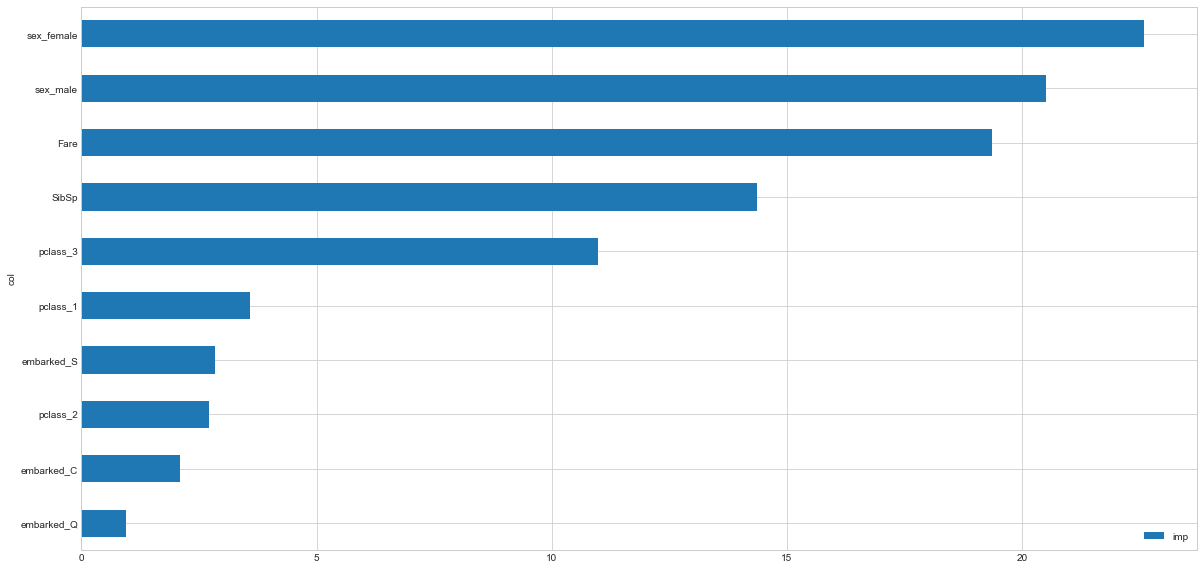

In [129]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

### Why would you want feature importance?
- Featrue importance shows how much each feature contributed to the model.

- You could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

- You could improve features which don't offer much to the overall model.

- Or you could improve features which offer more to the model. In this case, there aren't many ways you could improve sex as it's already a binary.

- Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

### Precision and Recall
**Precision** and **recall** are two metrics which are used for cases where you have have an imbalanced classification problem.

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

This is where precision an recall come in.

- **Recall:** a metric which measures a models ability to find all the relevant cases in a dataset. Recall would be the models ability to find the 1 person in 100,000 who has the disease.

- **Precision:** a metric which measures a models ability to correctly identify only relevant instances.

In our example, Precision would be if the model found the 1 person who had the disease, did they actually have the disease.

Combining the precision and recall, gives an F1 score.

These metrics will all fall between 0 and 1, with a higher value being better.

Although, they don't necessarily need to come into play for our Titantic problem, they're worth remembering for your future work.

In [133]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8394611182702931
Recall: 0.6573558823529413
F1: 0.7372859646170444
AUC: 0.8808659193185471


**Recall is low**, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

**Precision is higher**, therefore there's less false positives (predicting Survived, when it was actually Did not survive).

**Q**: What are some ways to visualise precision and recall? Hint: You may want to look into what a confusion matrix is, you can find much more information in this blog post: Beyond Accuracy: Precision and Recall

## Submission
Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset and then submit our predictions to Kaggle.

We want to make predictions on the same kind of columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.